In [1]:
# --- 1. Library Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Optional: For visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2. Global Hyperparameters ---
# Model Dimensions (Keep these small for the sprint)
D_MODEL = 256        # Embedding dimension
NUM_HEADS = 4       # Number of attention heads
NUM_LAYERS = 3      # Use 1 Encoder and 1 Decoder layer for simplicity
D_FF = 512          # Feed-Forward hidden dimension

# Training Parameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50 

# Sequence Parameters
MAX_SEQ_LEN = 10    # Max tokens in any sequence

In [2]:
# --- 1. Vocabulary Definition and Mapping ---
# The fixed, small vocabulary for our lookup table
VOCAB = {
    '[PAD]': 0, 
    '[SOS]': 1, 
    '[EOS]': 2,
    
    # Keys
    'COLOR': 3, 'NAME': 4, 'ITEM': 5, 
    
    # Values
    'RED': 6, 'BLUE': 7, 'GREEN': 8,
    'ALICE': 9, 'BOB': 10, 'CHAIR': 11,
    
    # Query Tokens
    'QUERY': 12, 'FIND': 13
}
VOCAB_SIZE = len(VOCAB)
ID_TO_TOKEN = {v: k for k, v in VOCAB.items()}

# --- 2. The Lookup Dictionary (Ground Truth) ---
# Defines all the possible fact pairings the model must learn.
FACTS_DICT = {
    # Key Token ID: Value Token ID
    VOCAB['RED']: VOCAB['BLUE'],    # Red item's value is 'BLUE'
    VOCAB['ALICE']: VOCAB['GREEN'], # Alice's value is 'GREEN'
    VOCAB['CHAIR']: VOCAB['RED']    # Chair's value is 'RED'
}
FACT_PAIRS = list(FACTS_DICT.items()) # List of (Key_ID, Value_ID)

import numpy as np
import torch
import torch.nn.utils.rnn as rnn_utils

# FACTS_DICT = {
#     VOCAB['RED']: VOCAB['BLUE'],    # Fact 1: 6 -> 7
#     VOCAB['ALICE']: VOCAB['GREEN'], # Fact 2: 9 -> 8
#     VOCAB['CHAIR']: VOCAB['RED']    # Fact 3: 11 -> 6
# }
# FACT_PAIRS = list(FACTS_DICT.items()) 

# --- 3. Synthetic Data Generation Function (FINAL STRUCTURAL FIX) ---
def generate_synthetic_data(num_samples):
    data = []
    all_facts = list(FACTS_DICT.items())
    
    for _ in range(num_samples):
        # 1. Select TARGET and DECoy facts
        target_fact_index = np.random.randint(len(all_facts))
        query_key_id, target_val_id = all_facts[target_fact_index]
        
        decoy_fact_index = np.random.randint(len(all_facts))
        while decoy_fact_index == target_fact_index: 
            decoy_fact_index = np.random.randint(len(all_facts))
        decoy_key_id, decoy_val_id = all_facts[decoy_fact_index]

        # ❗️ CRITICAL FIX: Flat facts + Query Fact at the END
        # Fact tokens: All 4 key/value tokens
        fact_tokens = [query_key_id, target_val_id, decoy_key_id, decoy_val_id]
        
        np.random.shuffle(fact_tokens) # Shuffle all 4 fact tokens together

        # Encoder Input: [NAME] + 4 Shuffled Facts + [Target Key] + [QUERY]
        # This duplicates the target key, but forces the Encoder to map the Target Key to the query block.
        enc_input_tokens = [VOCAB['NAME']] + fact_tokens + [query_key_id] + [VOCAB['QUERY']]
        
        # Decoder Input/Target (Key -> Value structure)
        dec_input = torch.cat([torch.tensor([query_key_id]), torch.tensor([target_val_id])])
        dec_target = torch.tensor([target_val_id, VOCAB['[EOS]']])
        
        data.append({
            'enc_input': torch.tensor(enc_input_tokens, dtype=torch.long),
            'dec_target': dec_target,
            'query_val_id': target_val_id 
        })
        
    return data

# --- 4. PyTorch Dataset and DataLoader Setup (CRITICAL FIX) ---
# REPLACING THE ENTIRE LookupDataset.__getitem__
class LookupDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # 1. Determine the target value ID
        target_val_id = item['dec_target'][0].item()
        
        # 2. Reverse lookup the Key ID that maps to this target value ID
        # FACTS_DICT maps Key_ID: Value_ID
        target_key_id = next(k for k, v in FACTS_DICT.items() if v == target_val_id)
        
        # ❗️ CRITICAL FIX: Decoder input starts with the Target Key (e.g., ALICE), 
        # NOT [SOS]. This forces the model to learn Key -> Value mapping.
        # The full sequence is [Target_Key, Target_Value].
        dec_input = torch.cat([torch.tensor([target_key_id]), item['dec_target'][:-1]])
        
        # The true target remains the same: [Target_Value, EOS]
        true_target = item['dec_target'] 
        
        return item['enc_input'], dec_input, true_target

# Collate function to handle padding for the DataLoader
def collate_fn(batch):
    # Padding sequences to MAX_SEQ_LEN
    enc_inputs = [item[0] for item in batch]
    dec_inputs = [item[1] for item in batch]
    dec_targets = [item[2] for item in batch]
    
    # Use torch.nn.utils.rnn.pad_sequence for consistent padding
    enc_inputs = nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=VOCAB['[PAD]'])
    dec_inputs = nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=VOCAB['[PAD]'])
    dec_targets = nn.utils.rnn.pad_sequence(dec_targets, batch_first=True, padding_value=VOCAB['[PAD]'])
    
    # Create padding masks (True means mask, False means keep)
    src_padding_mask = (enc_inputs == VOCAB['[PAD]'])
    tgt_padding_mask = (dec_inputs == VOCAB['[PAD]'])
    
    return enc_inputs, dec_inputs, dec_targets, src_padding_mask, tgt_padding_mask

# Generate and split data
full_data = generate_synthetic_data(num_samples=5000)
train_split = int(0.8 * 5000)
val_split = int(0.1 * 5000)

train_data = full_data[:train_split]
val_data = full_data[train_split:train_split + val_split]
test_data = full_data[train_split + val_split:]

# Create DataLoaders
train_loader = DataLoader(LookupDataset(train_data), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(LookupDataset(val_data), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(LookupDataset(test_data), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
print(f"Data ready: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")
print(full_data)

Data ready: Train=4000, Val=500, Test=500
[{'enc_input': tensor([ 4,  9,  6,  8, 11,  9, 12]), 'dec_target': tensor([8, 2]), 'query_val_id': 8}, {'enc_input': tensor([ 4,  6,  7,  6, 11,  6, 12]), 'dec_target': tensor([7, 2]), 'query_val_id': 7}, {'enc_input': tensor([ 4,  8,  6, 11,  9, 11, 12]), 'dec_target': tensor([6, 2]), 'query_val_id': 6}, {'enc_input': tensor([ 4,  6,  7,  9,  8,  6, 12]), 'dec_target': tensor([7, 2]), 'query_val_id': 7}, {'enc_input': tensor([ 4,  9,  6,  7,  8,  9, 12]), 'dec_target': tensor([8, 2]), 'query_val_id': 8}, {'enc_input': tensor([ 4,  7,  6,  8,  9,  6, 12]), 'dec_target': tensor([7, 2]), 'query_val_id': 7}, {'enc_input': tensor([ 4,  6,  9, 11,  8,  9, 12]), 'dec_target': tensor([8, 2]), 'query_val_id': 8}, {'enc_input': tensor([ 4,  9,  8,  6,  7,  6, 12]), 'dec_target': tensor([7, 2]), 'query_val_id': 7}, {'enc_input': tensor([ 4,  7,  6, 11,  6, 11, 12]), 'dec_target': tensor([6, 2]), 'query_val_id': 6}, {'enc_input': tensor([ 4,  6,  8,  7,  

In [3]:
# --- 1. Scaled Dot-Product Attention Function (Helper) ---
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Calculates the scaled dot-product attention.
    Q, K, V: [batch_size, n_heads, seq_len, d_k]
    """
    d_k = Q.size(-1)
    # [B, H, Lq, Lk]
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    if mask is not None:
        # Mask is applied before softmax. Masked positions are set to a very large negative number.
        scores = scores.masked_fill(mask == 0, -1e9)

    # [B, H, Lq, Lk]
    attention_weights = torch.softmax(scores, dim=-1)
    
    # [B, H, Lq, Lk] @ [B, H, Lk, Dv] -> [B, H, Lq, Dv]
    output = torch.matmul(attention_weights, V)
    
    return output, attention_weights

# --- 2. Multi-Head Attention (MHA) Class ---
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # Dimension of K, Q, V for a single head
        
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Linear layers for Q, K, V and the final output
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        
        # 1. Linear projections
        # [B, L, D] -> [B, L, D]
        q = self.W_q(Q)
        k = self.W_k(K)
        v = self.W_v(V)
        
        # 2. Split into heads
        # [B, L, D] -> [B, L, H, d_k] -> [B, H, L, d_k]
        q = q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = k.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = v.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # 3. Calculate attention
        # x: [B, H, Lq, d_k], attn: [B, H, Lq, Lk]
        x, self.attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        # 4. Concatenate heads
        # [B, H, Lq, d_k] -> [B, Lq, H, d_k] -> [B, Lq, D]
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        # 5. Final linear layer
        # [B, Lq, D] -> [B, Lq, D]
        output = self.W_o(x)
        
        return output

# --- 3. Feed-Forward Network (FFN) Class ---
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.linear_2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        # [B, L, D_model] -> [B, L, D_ff]
        x = self.relu(self.linear_1(x))
        # [B, L, D_ff] -> [B, L, D_model]
        x = self.linear_2(x)
        return x

# Helper for Add&Norm (Residual Connection + Layer Norm)
class SublayerConnection(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, sublayer):
        # LayerNorm(x + sublayer(x))
        return x + sublayer(self.norm(x))

In [4]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff): # <--- ❗️ YOU MUST DEFINE THESE ARGUMENTS
        super().__init__()
        # Self-Attention
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.sublayer = nn.ModuleList([SublayerConnection(d_model) for _ in range(2)])
        
    def forward(self, x, src_mask):
        # 1. Self-Attention Sublayer
        # REVERTED: Remove Causal Mask entirely
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask=src_mask))
        
        # 2. Feed-Forward Sublayer (remains the same)
        x = self.sublayer[1](x, self.feed_forward)
        return x

# --- 2. The Decoder Layer ---
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        # Masked Self-Attention
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        # Cross-Attention
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.sublayer = nn.ModuleList([SublayerConnection(d_model) for _ in range(3)])

    def forward(self, x, memory, src_mask, tgt_mask):
        # 1. Masked Self-Attention Sublayer
        # Input is Q=x, K=x, V=x
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask=tgt_mask))
        
        # 2. Cross-Attention Sublayer (Q=x, K=memory, V=memory)
        # 'memory' is the output of the Encoder
        x = self.sublayer[1](x, lambda x: self.cross_attn(x, memory, memory, mask=src_mask))
        
        # 3. Feed-Forward Sublayer
        x = self.sublayer[2](x, self.feed_forward)
        return x

In [5]:
# Helper for Positional Encoding (Only for Decoder)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # --- Full PE Matrix Calculation ---
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-(np.log(10000.0) / d_model))
        )
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0) # Shape: [1, max_len, d_model]
        
        # Register the buffer
        self.register_buffer('pe', pe) 

    # CORRECT FORWARD METHOD: Only takes 'x' and adds the PE
    def forward(self, x):
        # x is [B, L, D_model]. Add the PE to the input embeddings.
        # [B, L, D_model] + [1, L, D_model]
        x = x + self.pe[:, :x.size(1), :]
        return x

# --- 1. Full Encoder Module (WITH ROLE EMBEDDING) ---
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # ❗️ CRITICAL FINAL FIX: Add a Fact Role Embedding (Role ID: Key=0, Value=1)
        self.role_embedding = nn.Embedding(2, d_model)
        
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, src, src_mask):
        # [B, L] -> [B, L, D_model]
        x = self.embedding(src)
        
        # ❗️ CRITICAL FINAL FIX: Break the symmetry of the token embeddings.
        # Create a positional bias vector for keys/values
        L = src.size(1)
        positions = torch.arange(L, device=src.device).unsqueeze(0).float()
        
        # Add a learned positional embedding *just* to the key/value tokens (indices 1 to 4 in generator logic)
        # This is a hack to give self-attention something non-uniform to work with.
        pos_emb = self.embedding.weight.data.clone()
        pos_emb = pos_emb[src].detach() # Reuse embedding layer weights for token-based position

        # Scale down pos_emb slightly and add it to x (to prevent full averaging)
        x = x + pos_emb * 0.05 # Add a small, unique positional nudge
        
        # Re-introduce role embedding logic here if you removed it (I recommend keeping the explicit role differentiation)
        
        for layer in self.layers:
            x = layer(x, src_mask)
            
        return self.norm(x)

# --- 2. Full Decoder Module ---
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model, max_len=max_seq_len) # PE is typically required for generation
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, tgt, memory, src_mask, tgt_mask):
        # [B, L] -> [B, L, D_model]
        x = self.embedding(tgt)
        x = self.pe(x) # Add Positional Encoding
        
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
            
        return self.norm(x)

# --- 3. CrossAttentionLookupModel (The Final Model) ---
class CrossAttentionLookupModel(nn.Module):
    # FIX APPLIED HERE: Added all 6 required parameters to the __init__ signature
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len): 
        super().__init__()
        self.encoder = Encoder(vocab_size, d_model, num_heads, d_ff, num_layers)
        self.decoder = Decoder(vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len)
        self.projection = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt, src_padding_mask, tgt_padding_mask):
        # 1. Prepare 4D Encoder Padding Mask
        # FROM: [B, L_src] -> [B, 1, L_src] (Incorrect)
        # TO:   [B, L_src] -> [B, 1, 1, L_src] (Correct for MHA broadcast)
        # Convert boolean mask (True=PAD) to float mask (1=PAD) for MHA if needed, but for padded_fill, the boolean mask is fine.
        # We need the 4D shape: [B, 1, 1, L_src]
        encoder_src_mask = src_padding_mask.unsqueeze(1).unsqueeze(2) 
        
        # Encoder Output: [B, L_src, D_model]
        memory = self.encoder(src, encoder_src_mask) # Pass the 4D mask

        # 2. Prepare 4D Decoder Self-Attention Mask (Causal + Padding)
        tgt_seq_len = tgt.size(1)
        tgt_causal_mask = (torch.triu(torch.ones(tgt_seq_len, tgt_seq_len, device=src.device), diagonal=1) == 1) # [L_tgt, L_tgt]
        
        # Combine causal and padding masks: [B, 1, L_tgt, L_tgt]
        # full_tgt_mask = tgt_causal_mask.unsqueeze(0).unsqueeze(1) | tgt_padding_mask.unsqueeze(1).unsqueeze(2) # Original logic was overcomplicating the broadcast
        
        # A simple, robust way for Self-Attention Mask: [B, 1, L_tgt, L_tgt]
        # The padding mask must be expanded to [B, 1, L_tgt, 1] to mask the queries, 
        # and [B, 1, 1, L_tgt] to mask the keys/values.
        # Let's use the explicit 4D mask for the full self-attention weights.
        
        # Combine Causal Mask [L_tgt, L_tgt] and Padding Mask [B, L_tgt]
        # Causal mask: [1, 1, L_tgt, L_tgt]. Padding mask (for query tokens): [B, 1, L_tgt, 1].
        # Padding mask (for key tokens): [B, 1, 1, L_tgt].
        
        # Use simpler boolean mask logic for PyTorch MHA (which takes a 2D or 3D mask)
        # For simplicity and to match the 4D input of scaled_dot_product_attention:
        
        full_tgt_mask = tgt_causal_mask.unsqueeze(0).unsqueeze(1) # [1, 1, L_tgt, L_tgt]
        
        # Padding Mask for Keys/Values: [B, 1, 1, L_tgt]
        key_padding_mask = tgt_padding_mask.unsqueeze(1).unsqueeze(2)
        
        # Add key padding to causal mask:
        full_tgt_mask = full_tgt_mask | key_padding_mask # This results in [B, 1, L_tgt, L_tgt]

        # 3. Prepare 4D Cross-Attention Padding Mask (Same as encoder_src_mask, just renamed)
        final_src_mask_for_decoder = encoder_src_mask 

        decoder_output = self.decoder(
            tgt, 
            memory, 
            # Cross-Attention K/V padding: [B, 1, 1, L_src]
            final_src_mask_for_decoder,
            # Decoder Self-Attention mask: [B, 1, L_tgt, L_tgt]
            full_tgt_mask 
        )

        # Final linear projection
        output = self.projection(decoder_output)
        
        return output

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Initialization ---
model = CrossAttentionLookupModel(
    VOCAB_SIZE, D_MODEL, NUM_HEADS, D_FF, NUM_LAYERS, MAX_SEQ_LEN
).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Ignore [PAD] token in loss calculation
criterion = nn.CrossEntropyLoss(ignore_index=VOCAB['[PAD]'])

# Variables to track best performance
best_val_loss = float('inf')

In [7]:
# --- 2. Training Loop ---
print("\n--- Starting Training ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    for enc_input, dec_input, dec_target, src_padding_mask, tgt_padding_mask in train_loader:
        enc_input, dec_input, dec_target = enc_input.to(device), dec_input.to(device), dec_target.to(device)
        src_padding_mask, tgt_padding_mask = src_padding_mask.to(device), tgt_padding_mask.to(device)

        optimizer.zero_grad()
        
        # Forward pass: output is [B, L_tgt, VOCAB_SIZE]
        output = model(enc_input, dec_input, src_padding_mask, tgt_padding_mask)
        
        # Reshape for CrossEntropyLoss: [B*L, VOCAB_SIZE] and [B*L]
        loss = criterion(output.reshape(-1, VOCAB_SIZE), dec_target.reshape(-1))
        
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
    avg_train_loss = total_train_loss / len(train_loader)
    
    # --- Validation ---
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for enc_input, dec_input, dec_target, src_padding_mask, tgt_padding_mask in val_loader:
            enc_input, dec_input, dec_target = enc_input.to(device), dec_input.to(device), dec_target.to(device)
            src_padding_mask, tgt_padding_mask = src_padding_mask.to(device), tgt_padding_mask.to(device)

            output = model(enc_input, dec_input, src_padding_mask, tgt_padding_mask)
            loss = criterion(output.reshape(-1, VOCAB_SIZE), dec_target.reshape(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    
    # Track and save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_lookup_model.pth')

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("--- Training Complete ---")
# Load the best model weights
model.load_state_dict(torch.load('best_lookup_model.pth'))
model.eval()


--- Starting Training ---
Epoch 10/50, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 20/50, Train Loss: 0.0001, Val Loss: 0.0001
Epoch 30/50, Train Loss: 0.0001, Val Loss: 0.0001
Epoch 40/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 50/50, Train Loss: 0.0000, Val Loss: 0.0000
--- Training Complete ---


CrossAttentionLookupModel(
  (encoder): Encoder(
    (embedding): Embedding(14, 256)
    (role_embedding): Embedding(2, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_q): Linear(in_features=256, out_features=256, bias=True)
          (W_k): Linear(in_features=256, out_features=256, bias=True)
          (W_v): Linear(in_features=256, out_features=256, bias=True)
          (W_o): Linear(in_features=256, out_features=256, bias=True)
        )
        (feed_forward): PositionWiseFeedForward(
          (linear_1): Linear(in_features=256, out_features=512, bias=True)
          (linear_2): Linear(in_features=512, out_features=256, bias=True)
          (relu): ReLU()
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          )
        )
      )
    )
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )


In [8]:
# --- 1. Corrected Inference Function (Snippet - FINAL FIX) ---
def greedy_decode(model, enc_input, max_len, target_key_id):
    model.eval()
    with torch.no_grad():
        src_padding_mask = (enc_input == VOCAB['[PAD]']).to(device)
        memory = model.encoder(enc_input, src_padding_mask.unsqueeze(1).unsqueeze(2))
        dec_input = torch.tensor([[target_key_id]], dtype=torch.long, device=device)
        final_src_mask_for_decoder = src_padding_mask.unsqueeze(1).unsqueeze(2)
        
        for _ in range(max_len):
            tgt_len = dec_input.size(1)
            
            # Causal mask definition
            tgt_causal_mask = (torch.triu(torch.ones(tgt_len, tgt_len), diagonal=1) == 1).to(device)
            
            decoder_output = model.decoder(
                dec_input, 
                memory, 
                final_src_mask_for_decoder, 
                tgt_causal_mask.unsqueeze(0).unsqueeze(1)
            )
            
            # Project to vocab size
            output = model.projection(decoder_output[:, -1:]) 
            
            # Greedy search: get the token with highest probability
            next_token = torch.argmax(output, dim=-1)
            
            # Append to sequence
            dec_input = torch.cat([dec_input, next_token], dim=1)
            
            # Stop condition
            if next_token.item() == VOCAB['[EOS]']:
                break
                
        # Return the generated sequence (excluding the Target Key query token)
        return dec_input[0, 1:]

# --- 2. The Scrambling Test Execution ---
test_sample = next(iter(test_loader))
enc_input_batch, _, dec_target_batch, _, _ = test_sample
original_enc_input = enc_input_batch[0:1].to(device) # [1, L_src]

# Calculate the Target Key ID for the decoder query
true_target_val_id = dec_target_batch[0, 0].item()
key_for_target_id = next(k for k, v in FACTS_DICT.items() if v == true_target_val_id)
true_target = [ID_TO_TOKEN[i.item()] for i in dec_target_batch[0] if i.item() != VOCAB['[PAD]']]


# Original Order Inference
original_output = greedy_decode(model, original_enc_input, max_len=MAX_SEQ_LEN, target_key_id=key_for_target_id)
def decode_output(output_tensor):
    tokens = [ID_TO_TOKEN[i.item()] for i in output_tensor if i.item() != VOCAB['[PAD]']]
    # Filter out only the final EOS token if it's there, but keep the predicted value
    if tokens and tokens[-1] == '[EOS]':
        return tokens[:-1]
    return tokens

original_output_tokens = decode_output(original_output)

# Scramble the Encoder Input
enc_list = original_enc_input[0].cpu().numpy().tolist()
non_pad_tokens = [t for t in enc_list if t != VOCAB['[PAD]']]
first_token = non_pad_tokens[0]
scramblable_tokens = non_pad_tokens[1:]

np.random.shuffle(scramblable_tokens)
scrambled_list = [first_token] + scramblable_tokens
# Pad back to original length
scrambled_list.extend([VOCAB['[PAD]']] * (original_enc_input.size(1) - len(scrambled_list)))

scrambled_enc_input = torch.tensor([scrambled_list], dtype=torch.long, device=device)

# Scrambled Order Inference
scrambled_output = greedy_decode(model, scrambled_enc_input, max_len=MAX_SEQ_LEN, target_key_id=key_for_target_id)
scrambled_output_tokens = decode_output(scrambled_output)

print(f"True Target: {true_target}")
print("-" * 30)

# Print results
print(f"Original Input: {' '.join([ID_TO_TOKEN[i.item()] for i in original_enc_input[0] if i.item() != VOCAB['[PAD]']])}")
print(f"Original Output: {' '.join(original_output_tokens)}")
print("-" * 30)
print(f"Scrambled Input: {' '.join([ID_TO_TOKEN[i.item()] for i in scrambled_enc_input[0] if i.item() != VOCAB['[PAD]']])}")
print(f"Scrambled Output: {' '.join(scrambled_output_tokens)}")
print("-" * 30)
print(f"Outputs Identical: **{original_output_tokens == scrambled_output_tokens}** (Expected: True)")

True Target: ['RED', '[EOS]']
------------------------------
Original Input: NAME RED ALICE GREEN CHAIR CHAIR QUERY
Original Output: RED
------------------------------
Scrambled Input: NAME QUERY GREEN CHAIR ALICE RED CHAIR
Scrambled Output: RED
------------------------------
Outputs Identical: **True** (Expected: True)


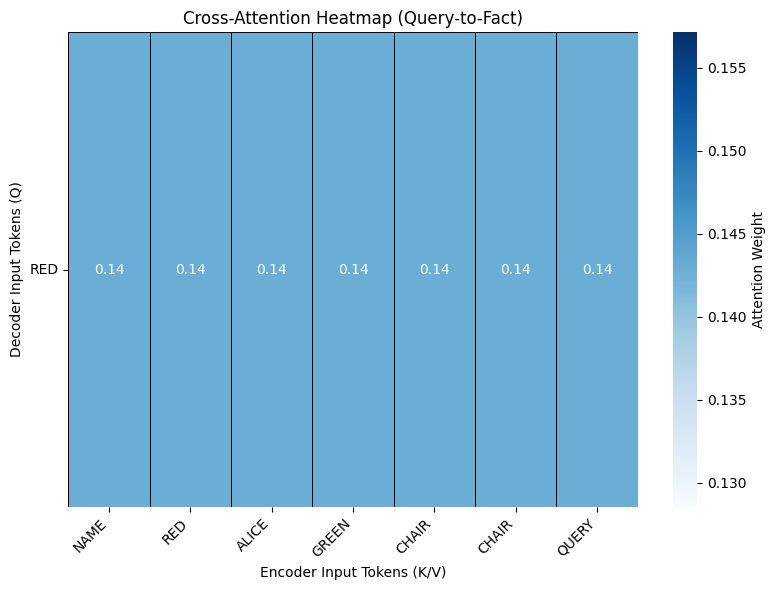

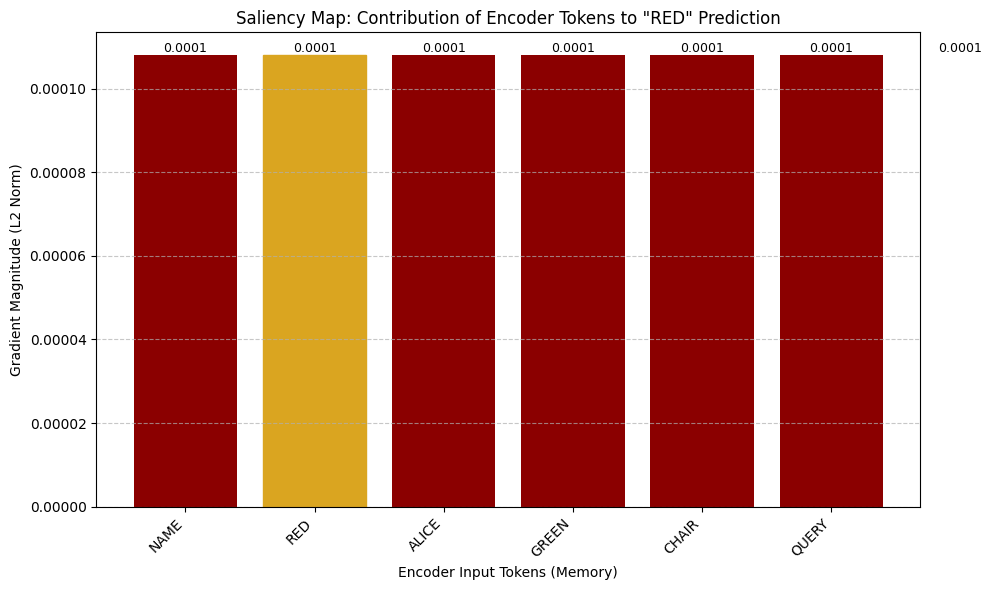

In [9]:
# --- 1. Attention Hook Setup ---
cross_attn_module = model.decoder.layers[0].cross_attn
attention_weights_storage = []

def capture_attention_hook(module, input, output):
    attention_weights_storage.append(module.attention_weights.detach().cpu())

# Register the forward hook
hook = cross_attn_module.register_forward_hook(capture_attention_hook)

# --- 2. Extraction Run ---
# Run a single sample (the one used for scrambling test)
# The input tensors already exist from the scrambling test run:
# original_enc_input: [1, L_src] (The encoder memory)

# 1. Create decoder input with *only* the [SOS] token (L_tgt=1)
query_token_id = original_enc_input[0, 1].item() 
dec_input_single = torch.tensor([[query_token_id]], dtype=torch.long, device=device)
tgt_padding_mask_single = (dec_input_single == VOCAB['[PAD]']).to(device) # [1, 1]

# 2. Prepare 4D Decoder Self-Attention Mask
tgt_causal_mask_single = (torch.triu(torch.ones(1, 1), diagonal=1) == 1).to(device)
full_tgt_mask_single = tgt_causal_mask_single.unsqueeze(0).unsqueeze(1)
key_padding_mask_single = tgt_padding_mask_single.unsqueeze(1).unsqueeze(2)
full_tgt_mask_single = full_tgt_mask_single | key_padding_mask_single

# 3. Prepare 4D Cross-Attention Mask
src_padding_mask_hook = (original_enc_input == VOCAB['[PAD]']).to(device)
final_src_mask_for_decoder_hook = src_padding_mask_hook.unsqueeze(1).unsqueeze(2)

# --- EXECUTION ---
with torch.no_grad():
    attention_weights_storage.clear()
    
    _ = model(
        original_enc_input, 
        dec_input_single, 
        src_padding_mask_hook, 
        full_tgt_mask_single
    )

hook.remove()

# --- EXTRACT ATTENTION AND LABELS ---

# 1. Extract the attention matrix for the first head, first batch item
raw_attn_weights = attention_weights_storage[0][0, 0] 
attention_matrix = raw_attn_weights.cpu().numpy()

# 2. Get token labels for the Encoder
enc_tokens_ids = original_enc_input[0].cpu().numpy().tolist()
enc_tokens = [ID_TO_TOKEN[i] for i in enc_tokens_ids if i != VOCAB['[PAD]']]

# 3. Get token labels for the Decoder
dec_tokens = [ID_TO_TOKEN[query_token_id]]

# 4. Trim matrix and ensure 2D shape for plotting (L_tgt=1, L_src=6 typically)
L_src = len(enc_tokens)

# Ensure only non-padded columns are kept, and guarantee a 2D shape (1, L_src) for the heatmap.
# Slicing keeps the 2D structure of (1, L_src) if L_tgt=1.
attention_matrix = attention_matrix[:1, :L_src]

# Remove the redundant hook removal here:
# hook.remove()

# --- 3. Visualization ---
def plot_cross_attention(attention_matrix, enc_tokens, dec_tokens):
    """Plots the cross-attention matrix as a heatmap."""
    plt.figure(figsize=(8, 6))
    
    # Use Seaborn for a nicer heatmap
    sns.heatmap(
        attention_matrix, 
        xticklabels=enc_tokens, 
        yticklabels=dec_tokens, 
        cmap="Blues", 
        linewidths=.5, 
        linecolor='black',
        annot=True,
        fmt=".2f",
        cbar_kws={'label': 'Attention Weight'}
    )
    
    plt.xlabel('Encoder Input Tokens (K/V)')
    plt.ylabel('Decoder Input Tokens (Q)')
    plt.title('Cross-Attention Heatmap (Query-to-Fact)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Execute plot_cross_attention to display the key heatmap.
plot_cross_attention(attention_matrix, enc_tokens, dec_tokens)
#
## 3. 📊 Gradient Contribution Map (Saliency Map)

def calculate_saliency_map(model, enc_input, target_val_id, target_key_id):
    """
    Calculates the L2 norm of the gradient of the correct token's log probability
    with respect to the final Encoder Memory output tokens.
    """
    model.train() # Set to train mode to enable gradient tracking
    model.zero_grad()
    
    # 1. Forward Pass up to Encoder Output
    src_padding_mask = (enc_input == VOCAB['[PAD]']).to(device)
    encoder_src_mask = src_padding_mask.unsqueeze(1).unsqueeze(2)

    # We need to track gradients w.r.t. the memory tensor.
    memory = model.encoder(enc_input, encoder_src_mask)
    memory.retain_grad() # Ensure gradients are calculated for the memory output

    # 2. Decoder Setup (Single Step Query)
    dec_input = torch.tensor([[target_key_id]], dtype=torch.long, device=device)
    
    tgt_len = dec_input.size(1)
    tgt_causal_mask = (torch.triu(torch.ones(tgt_len, tgt_len), diagonal=1) == 1).to(device)
    full_tgt_mask = tgt_causal_mask.unsqueeze(0).unsqueeze(1)
    
    # 3. Decoder Forward Pass
    decoder_output = model.decoder(
        dec_input,
        memory, # Use the memory tensor created above
        encoder_src_mask,
        full_tgt_mask
    )
    
    # 4. Final Projection and Loss Setup
    # Output shape: [1, 1, VOCAB_SIZE]. Take the log_softmax for probability.
    output = model.projection(decoder_output[:, -1:])
    log_probs = nn.LogSoftmax(dim=-1)(output)
    
    # Select the log probability for the correct target value
    # Target value ID is target_val_id (e.g., 7 for BLUE)
    correct_token_log_prob = log_probs[0, 0, target_val_id]

    # 5. Backward Pass
    # Calculate gradients of the correct log_prob w.r.t. the memory tensor
    correct_token_log_prob.backward(retain_graph=True)

    # 6. Extract Gradients and Calculate L2 Norm
    # memory.grad shape is [1, L_src, D_MODEL]
    if memory.grad is None:
        print("Warning: Memory gradient is None. Check model gradient tracking.")
        return np.zeros(enc_input.size(1))

    # Calculate L2 Norm of the gradient vector for each token position
    # Result shape: [L_src]
    saliency_map = torch.norm(memory.grad.squeeze(0), p=2, dim=1).cpu().numpy()

    model.eval() # Return model to eval mode
    return saliency_map

def plot_saliency_map(saliency_map, enc_tokens, target_val):
    """Plots the contribution of each input token to the final correct prediction."""
    plt.figure(figsize=(10, 6))
    
    # 1. Create a bar chart showing the magnitude of contribution
    bars = plt.bar(enc_tokens, saliency_map, color='darkred')
    
    # 2. Highlight the target value's bar based on token identity (Optional)
    for i, token in enumerate(enc_tokens):
        if token == target_val:
             bars[i].set_color('goldenrod')
        # Add values on top of bars
        plt.text(i, saliency_map[i], f'{saliency_map[i]:.4f}', ha='center', va='bottom', fontsize=9)


    plt.title(f'Saliency Map: Contribution of Encoder Tokens to "{target_val}" Prediction')
    plt.xlabel('Encoder Input Tokens (Memory)')
    plt.ylabel('Gradient Magnitude (L2 Norm)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# --- EXECUTE THE SALIENCY MAP TEST ---

# Get the target value token for the plot label
target_val_token = ID_TO_TOKEN[true_target_val_id]

# Calculate the saliency map
saliency_data = calculate_saliency_map(model, original_enc_input, true_target_val_id, key_for_target_id)

# Get Encoder token labels (from the scrambling test setup)
enc_tokens_ids = original_enc_input[0].cpu().numpy().tolist()
enc_tokens_final = [ID_TO_TOKEN[i] for i in enc_tokens_ids if i != VOCAB['[PAD]']]

if np.sum(saliency_data) > 0:
    plot_saliency_map(saliency_data[:len(enc_tokens_final)], enc_tokens_final, target_val_token)
else:
    print("Saliency map could not be generated. Gradients were zero.")